In [2]:
import os
import pathlib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [18]:
pwd

'/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/notebook'

In [7]:
with open('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data_FAILED/1a0j_final.pdb', 'r') as f:
    lines = f.readlines()

In [8]:
headings=[line.split()[0] for line in lines]

In [9]:
# Unique headings in the PDB file.
np.unique(headings)

array(['ATOM', 'COMPND', 'CRYST1', 'EXPDTA', 'FORMUL', 'HEADER', 'HET',
       'HETNAM', 'LINK', 'REMARK', 'SEQRES', 'SOURCE', 'SSBOND', 'TER'],
      dtype='<U6')

In [19]:
# "SEQRES": sequence of residues in each chain.
# "ATOM": atom information.
# "TER": end of chain.
# "HETATM"/"HET": heterogen atom information.
# "CONECT": connectivity information.
# "END": end of file.
# "REMARK": remark.
# "MODEL": model information. 
# "SSBOND": disulfide bond information. 
# "CRYST1": unit cell information.  

## 1. # of residues in each protein.

In [10]:
def get_residues_dict(file):
    # Generate a dictionary of residues from a PDB file. Input: PDB file. Output: dictionary of residues.
    with open(file, 'r') as f:
        lines = f.readlines()

    # Collect all residues from the line "SEQRES"
    # Example: "SEQRES   1 D  223  ILE VAL GLY GLY TYR GLU CYS ARG LYS ASN SER ALA SER"
    residues_dict={"chain":[], "total_res": [],"residues":[]} 
    # "chain": chain ID. "total_res": total number of residues in the chain. "residues": list of residues in the chain.
    # residues = []
    for line in lines:
        if line.startswith("SEQRES"):
            residues_dict["chain"].append(line.split()[2])
            residues_dict["total_res"].append(int(line.split()[3]))
            residues_dict["residues"].append(line.split()[4:])   
    # Generate list of chains (unique elements).
    chains = list(set(residues_dict["chain"]))
    clean_residues_dict = {"chain":[], "total_res": [], "residues":[]}
    for c in chains: # B, D, A, C.
        res_per_chain = []
        total = None  # Initialize total before the loop
        for i, chain in enumerate(residues_dict["chain"]):
            # Process on chain at a time.
            if chain == c:
                res_per_chain.append(residues_dict["residues"][i])
                total = residues_dict["total_res"][i]
        clean_residues_dict["residues"].append(res_per_chain)
        if total is not None:  # Only append if total was assigned
            clean_residues_dict["total_res"].append(total)
        else:
            # Handle the case where no matching chain was found
            clean_residues_dict["total_res"].append(np.NaN)  # or some other default value
        clean_residues_dict["chain"] = chains 

    return clean_residues_dict

In [11]:
# The total number of residues in each protein is the sum of residue # in each chain.
file = '/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data_FAILED/1a0j_final.pdb'
res_dict = get_residues_dict(file)
np.sum(res_dict["total_res"])

np.int64(892)

In [12]:
pd.DataFrame(res_dict)   

,chain,total_res,residues
0,A,223,"[[ILE, VAL, GLY, GLY, TYR, GLU, CYS, ARG, LYS,..."
1,C,223,"[[ILE, VAL, GLY, GLY, TYR, GLU, CYS, ARG, LYS,..."
2,B,223,"[[ILE, VAL, GLY, GLY, TYR, GLU, CYS, ARG, LYS,..."
3,D,223,"[[ILE, VAL, GLY, GLY, TYR, GLU, CYS, ARG, LYS,..."


In [71]:
# Loop through all proteins. 
pdb_path = pathlib.Path('/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/pdb_redo_data')
pdbs = list(pdb_path.glob('*_final.pdb')) # Pay attention to the pattern of names. A general "*.pdb" would result in duplicate files when looping.

In [72]:
# Store pdbs as dictionary of pdb name and total # of res in each pdb.
# Could store the dictionary as well.
num_res_pdbs={"name":[], "num_res":[], "num_chain":[], "res_dict": []}
for pdb in pdbs:
    name = pdb.stem.split('_')[0]
    res_dict = get_residues_dict(pdb)
    num_res = np.sum(res_dict["total_res"])
    if num_res > 0:
        num_res_pdbs["name"].append(name)
        num_res_pdbs["num_res"].append(num_res)
        num_res_pdbs["num_chain"].append(len(res_dict["chain"]))
        num_res_pdbs["res_dict"].append(res_dict)
    else:
        print(f"No residues found in {pdb}")
# pd.DataFrame(num_res_pdbs)



In [73]:
df_res = pd.DataFrame(num_res_pdbs)

In [94]:
df_res.to_pickle('df_1_res.pckl')

In [26]:
# Training set.
train_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/train_split.txt", header=None)
train_list = train_list[0].tolist()
train_list[:10]

['2wyt',
 '5yde',
 '6sso',
 '4h0b',
 '5quu',
 '2r6v',
 '3qzb',
 '6eox',
 '5z95',
 '4o6t']

In [27]:
# Test set.
test_list = pd.read_csv("/Users/mingbin/Desktop/Wankowicz_lab_Mac/Projects/water/data/test_split.txt", header=None)
test_list = test_list[0].tolist()
test_list[:10]

['6ym8',
 '5pu7',
 '7su4',
 '6k17',
 '2ovy',
 '5pes',
 '4ngy',
 '3nd1',
 '7o3q',
 '7rws']

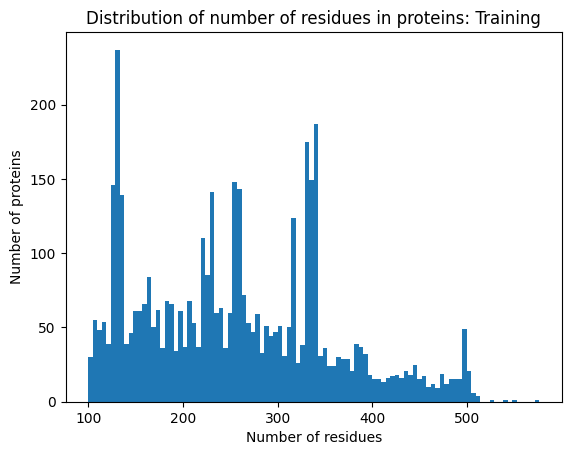

In [74]:
df=df_res[df_res.name.isin(train_list)]
plt.hist(df.num_res, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Training")
plt.savefig("figures/train_res_dist.png", dpi=200)
plt.show()

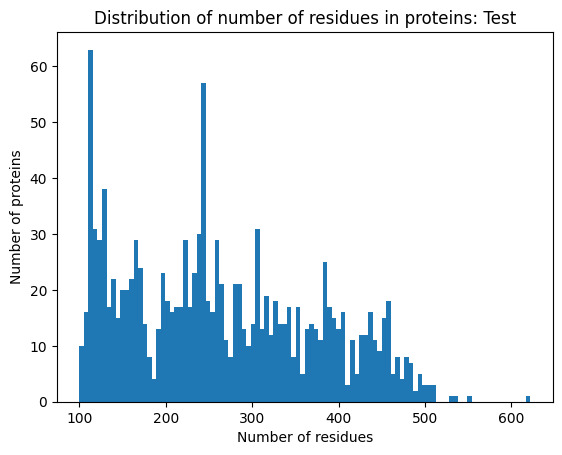

In [75]:
df=df_res[df_res.name.isin(test_list)]
plt.hist(df.num_res, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of residues in proteins: Test")
plt.savefig("figures/test_res_dist.png", dpi=200)
plt.show()

#### 1.1 Distribution of number of residues.

In [76]:
df_res

,name,num_res,num_chain,res_dict
0,7lmj,306,1,"{'chain': ['A'], 'total_res': [306], 'residues..."
1,4pqw,91,1,"{'chain': ['A'], 'total_res': [91], 'residues'..."
2,4zax,207,1,"{'chain': ['A'], 'total_res': [207], 'residues..."
3,6zw2,486,2,"{'chain': ['A', 'B'], 'total_res': [244, 242],..."
4,8otp,258,1,"{'chain': ['A'], 'total_res': [258], 'residues..."
...,...,...,...,...
40843,6gd4,1000,4,"{'chain': ['A', 'C', 'B', 'D'], 'total_res': [..."
40844,3av9,316,4,"{'chain': ['A', 'Y', 'B', 'X'], 'total_res': [..."
40845,2z6t,151,1,"{'chain': ['A'], 'total_res': [151], 'residues..."
40846,1yux,402,2,"{'chain': ['A', 'B'], 'total_res': [200, 202],..."


In [77]:
df_res[(df_res.num_res > 400) & (df_res.num_chain == 1)]

,name,num_res,num_chain,res_dict
33,4hr3,407,1,"{'chain': ['A'], 'total_res': [407], 'residues..."
96,5jxm,405,1,"{'chain': ['A'], 'total_res': [405], 'residues..."
133,6f9l,485,1,"{'chain': ['A'], 'total_res': [485], 'residues..."
141,7p9r,524,1,"{'chain': ['A'], 'total_res': [524], 'residues..."
155,6j3x,415,1,"{'chain': ['A'], 'total_res': [415], 'residues..."
...,...,...,...,...
40770,3ejs,1045,1,"{'chain': ['A'], 'total_res': [1045], 'residue..."
40812,3vkq,538,1,"{'chain': ['A'], 'total_res': [538], 'residues..."
40818,3nrs,437,1,"{'chain': ['A'], 'total_res': [437], 'residues..."
40824,4rjw,426,1,"{'chain': ['A'], 'total_res': [426], 'residues..."


In [78]:
df_train=df_res[df_res.name.isin(train_list)]
df_test=df_res[df_res.name.isin(test_list)]

In [79]:
print('Training set: ', len(df_train))
print('Test set: ', len(df_test))

Training set:  4507
Test set:  1293


In [80]:
len(train_list)

4507

In [81]:
len(set(train_list)) # training set list does not have duplicates.

4507

In [83]:
# df_train[df_train.duplicated()]
df_train.name.is_unique # There are NO duplicate elements now.

True

In [84]:
df_train[df_train.name.duplicated() == True] # 5n5g was duplicated before. Change looping pattern to "*_final.pdb"

,name,num_res,num_chain,res_dict


In [85]:
# Extend all residue counts into a single list - training set.
flatten_res_list_train = []
for res_dict in df_train.res_dict.values:
    flatten_res_list_train.extend(res_dict['total_res'])

In [86]:
# Extend all residue counts into a single list - test set.
flatten_res_list_test = []
for res_dict in df_test.res_dict.values:
    flatten_res_list_test.extend(res_dict['total_res'])

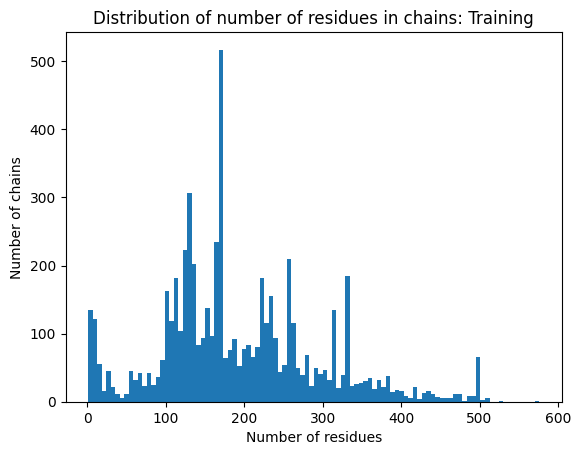

In [87]:
# Train.
plt.hist(flatten_res_list_train, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Training")
plt.savefig("figures/train_res_chain_dist.png", dpi=200)
plt.show()

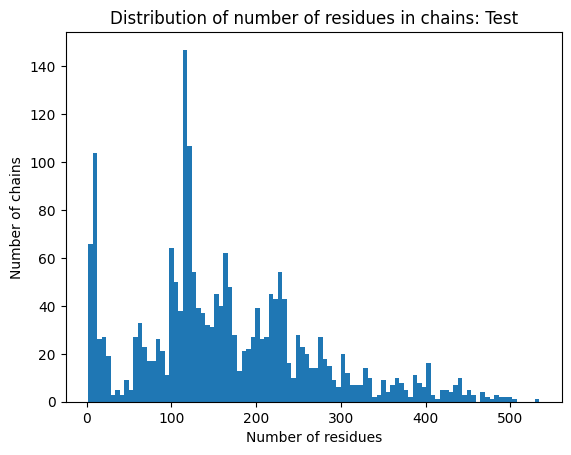

In [88]:
# Test.
plt.hist(flatten_res_list_test, bins=100)
plt.xlabel("Number of residues")
plt.ylabel("Number of chains")
plt.title("Distribution of number of residues in chains: Test")
plt.savefig("figures/test_res_chain_dist.png", dpi=200)
plt.show()

#### 1.2 Number of PDBs versus Number of chains.

In [89]:
df_train

,name,num_res,num_chain,res_dict
14,3lez,260,1,"{'chain': ['A'], 'total_res': [260], 'residues..."
17,7sie,255,1,"{'chain': ['A'], 'total_res': [255], 'residues..."
23,6rt3,129,1,"{'chain': ['A'], 'total_res': [129], 'residues..."
49,3qx5,290,3,"{'chain': ['I', 'H', 'L'], 'total_res': [11, 2..."
55,2hph,316,1,"{'chain': ['A'], 'total_res': [316], 'residues..."
...,...,...,...,...
40826,5l2v,332,2,"{'chain': ['A', 'B'], 'total_res': [166, 166],..."
40827,8pb7,320,1,"{'chain': ['A'], 'total_res': [320], 'residues..."
40828,6eau,231,2,"{'chain': ['A', 'I'], 'total_res': [223, 8], '..."
40831,5kxl,129,1,"{'chain': ['A'], 'total_res': [129], 'residues..."


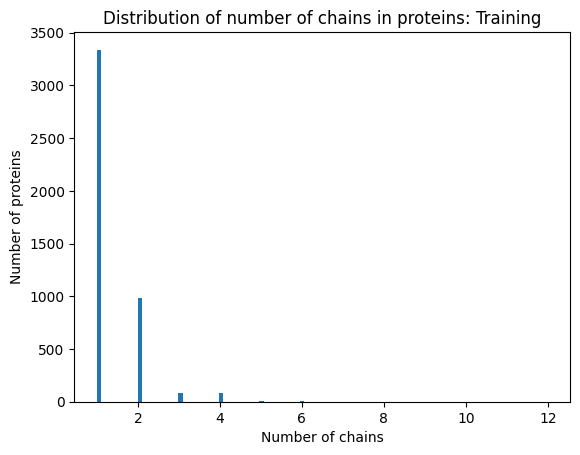

In [90]:
plt.hist(df_train.num_chain, bins=100)
plt.xlabel("Number of chains")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of chains in proteins: Training")
plt.savefig("figures/train_chain_dist.png", dpi=200)
plt.show()

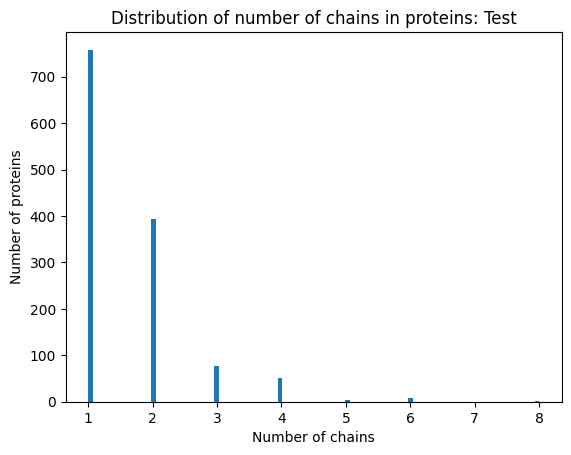

In [91]:
plt.hist(df_test.num_chain, bins=100)
plt.xlabel("Number of chains")
plt.ylabel("Number of proteins")
plt.title("Distribution of number of chains in proteins: Test")
plt.savefig("figures/test_chain_dist.png", dpi=200)
plt.show()

#### 1.3 PDBs with chains with larger than 500 residues.

In [92]:
df_train[df_train.num_res > 500]

,name,num_res,num_chain,res_dict
278,5e2f,540,2,"{'chain': ['A', 'B'], 'total_res': [270, 270],..."
853,4u2l,510,1,"{'chain': ['A'], 'total_res': [510], 'residues..."
1874,4xmr,508,2,"{'chain': ['A', 'B'], 'total_res': [254, 254],..."
4617,8oed,508,1,"{'chain': ['A'], 'total_res': [508], 'residues..."
14823,3o1n,552,2,"{'chain': ['A', 'B'], 'total_res': [276, 276],..."
17095,4pq9,514,2,"{'chain': ['A', 'B'], 'total_res': [257, 257],..."
23293,3i4g,528,1,"{'chain': ['A'], 'total_res': [528], 'residues..."
23965,4xwr,510,1,"{'chain': ['A'], 'total_res': [510], 'residues..."
28202,3gyi,504,1,"{'chain': ['A'], 'total_res': [504], 'residues..."
28257,6w3r,508,2,"{'chain': ['A', 'B'], 'total_res': [254, 254],..."


In [96]:
df_train_L500 = df_train[df_train.num_res > 500]
df_train_L500.name.to_csv('train_over_500res.txt', header=False, index=False)

In [93]:
df_test[df_test.num_res > 500]

,name,num_res,num_chain,res_dict
1195,1w1o,534,1,"{'chain': ['A'], 'total_res': [534], 'residues..."
8240,7s5o,507,3,"{'chain': ['A', 'C', 'B'], 'total_res': [169, ..."
11465,2qiw,510,2,"{'chain': ['A', 'B'], 'total_res': [255, 255],..."
17348,1vdw,508,2,"{'chain': ['A', 'B'], 'total_res': [254, 254],..."
19105,2ol7,502,2,"{'chain': ['A', 'B'], 'total_res': [251, 251],..."
21007,3ikn,531,3,"{'chain': ['A', 'C', 'B'], 'total_res': [177, ..."
29968,6qf9,510,2,"{'chain': ['A', 'B'], 'total_res': [255, 255],..."
37930,3nd1,550,2,"{'chain': ['A', 'B'], 'total_res': [275, 275],..."
38292,2h9b,622,2,"{'chain': ['A', 'B'], 'total_res': [311, 311],..."
39184,2yp9,503,1,"{'chain': ['A'], 'total_res': [503], 'residues..."


In [97]:
df_test_L500 = df_test[df_test.num_res > 500]
df_test_L500.name.to_csv('test_over_500res.txt', header=False, index=False)